<img src="../media/images/Front_page.png" style="width:1000px;">

## Can "fuel poverty" be estimated simply?

The Department for Business, Energy and Industrial Strategy produce estimates of fuel poverty to aid government policy. As part of the CFG Data Science Nanodegree, the authors have created this group project to explore fuel poverty statistics and investigate whether the incidence of fuel poverty can be predicted with limited indicators. If so, indicators such as those collected at the grass roots level (like in Job Centre Plus Offices) could be used to determine quickly those sufferring fuel poverty and qualifying for schemes targetted at the households.

In [1]:
# Necessary imports for code to work
# Sorted in alphabetical order for ease of updating
# Import keyword
import io
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pymysql
import scipy.special
import scipy.stats
import seaborn as sns
import sklearn.linear_model
import statsmodels
import warnings

# From keyword
from IPython.display import Image
from IPython.display import Math
from itertools import product
from matplotlib.pylab import rcParams
from pprint import pprint
from six import StringIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, confusion_matrix, roc_curve, accuracy_score, precision_score)
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Settings etc
rcParams['figure.figsize'] = 15, 12
%matplotlib inline
sns.set_style('white')
sns.set_context('notebook')
warnings.filterwarnings('ignore')

# Select the mysqlconnector that works for you - XAMPP passwd='', mysqlworkbench passwd='password'
conn=pymysql.connect(host='127.0.0.1',port=int(3306),user='root',passwd='',db='Fuel_poverty')
# conn=pymysql.connect(host='127.0.0.1',port=int(3306),user='root',passwd='password',db='Fuel_poverty')

## Dataset construction and cleaning
### Author: Hazel

The original datasets we selected totalled nearly 300, 000 rows of values spread over 40 columns. This made the dataset difficult to manipulate on our local machines, so we decided to select a subset of the data. We opted to collect a fairly large volume of data (from a longer time series) and started sourcing data from 2014 onwards. This decision was made as a new measure (region as gorEHS) was introduced and it meant that we would be able to make predictions of the likelihood of one being in fuel poverty based on region as well as the other chosen factors. This meant that the data would be consistent. A downside of this, however, is that 5 years does not represent a long term trend and thus we had to be careful when making predictions. This means that we would be unable to make any long term predictions based on this dataset alone.

The plus side to trimming the dataset was that queries ran faster and plotting was a lot clearer due to reduced interference and fuzz from the larger dataset.

One caveat about the below dataset construction and cleaning sets undertaken below is the ineffeciency of the code. Due to the ever changing nature of the project, and the inconsistency in column headings it made using loops a little tricky. One of the next steps to take would be to refactor this code into a more efficient format. This would not only save filespace but would most likely run faster as well. 

Finally, the main steps of dataset construction and cleaning are noted as python comments below. Whilst some of these steps may be self evident (reading in a csv for example) they have all been outlined in order to ensure that someone who is not familiar with python and its coding conventions would be able to read along and understand what each step in the process was meant to do and how we undertook them, should someone wish to replicate this activity elsewhere.

In [3]:
###################################################################################################################
# This cell has already been run and data processing has been completed. 
# Relevant files have been referenced approriately in the file structure.
# Please do not run this cell again, as it may threaten the validity of the datasets and disrupt the outputs.
# This code is here for reference only.
###################################################################################################################

# Updating csv files to only have relevant columns

# Assigning variable for file read
#f2014 = pd.read_csv("data/unprocessed/2014.csv")
#f2015 = pd.read_csv("data/unprocessed/2015.csv")
#f2016 = pd.read_csv("data/unprocessed/2016.csv")
#f2017 = pd.read_csv("data/unprocessed/2017.csv")
#f2018 = pd.read_csv("data/unprocessed/2018.csv")
#f2019 = pd.read_csv("data/unprocessed/2019.csv")

# Assigning wanted columns to a variable for printing
#w14 = f2014[['fuelexpn', 'hhcompx', 'gorEHS', 'FullincDeciles', 'FPEER', 'FPEERband', 'AHCIncomeEQ', 'fpflgb', 'fpflgf', 'HousingCosts']]
#w15 = f2015[['fuelexpn', 'hhcompx', 'gorEHS', 'FullincDeciles', 'FPEERrating', 'FPEERband', 'AHCIncomeEQ', 'fpflgb', 'fpflgf', 'HousingCosts']]
#w16 = f2016[['fuelexpn', 'hhcompx', 'gorEHS', 'FullincDeciles', 'FPEERrating', 'FPEERband', 'AHCIncomeEQ', 'fpflgb', 'fpflgf', 'HousingCosts']]
#w17 = f2017[['fuelexpn', 'hhcompx', 'gorehs', 'FullincDeciles', 'FPEERrating', 'FPEERband', 'AHCIncomeEQ', 'fpflgb', 'fpflgf', 'HousingCosts']]
#w18 = f2018[['fuelexpn', 'hhcompx', 'gorehs', 'FullincDeciles', 'FPEERrating', 'FPEERband', 'AHCIncomeEQ', 'fpflgb', 'fpflgf', 'HousingCosts']]
#w19 = f2019[['fuelexpn', 'hhcompx', 'gorehs', 'FullincDeciles', 'FPEERrating', 'FPEERband', 'AHCIncomeEQ_LILEE', 'fpflgb', 'fpflgf', 'HousingCosts']]


# Write to a new file
#w14.to_csv("data/unprocessed/2014.csv")
#w15.to_csv("data/unprocessed/2015.csv")
#w16.to_csv("data/unprocessed/2016.csv")
#w17.to_csv("data/unprocessed/2017.csv")
#w18.to_csv("data/unprocessed/2018.csv")
#w19.to_csv("data/unprocessed/2019.csv")

# Combining seperate csv files into one master file

# Find folder containing data
#os.chdir("data/processed")

# Select file type
#extension = 'csv'

# Loop through folder contents
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

# Combine all files in the list
#combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

# Export to csv
#combined_csv.to_csv( "data/dataset/master.csv", index=False, encoding='utf-8-sig')

# Split master file into test and train files in dataset folder

# Reading data as dataframes
#df14 = pd.read_csv("data/processed/2014.csv")
#df15 = pd.read_csv("data/processed/2015.csv")
#df16 = pd.read_csv("data/processed/2016.csv")
#df17 = pd.read_csv("data/processed/2017.csv")
#df18 = pd.read_csv("data/processed/2018.csv")
#df19 = pd.read_csv("data/processed/2019.csv")

# Splitting dataframes
#df14['split'] = np.random.randn(df14.shape[0], 1)
#df15['split'] = np.random.randn(df15.shape[0], 1)
#df16['split'] = np.random.randn(df16.shape[0], 1)
#df17['split'] = np.random.randn(df17.shape[0], 1)
#df18['split'] = np.random.randn(df18.shape[0], 1)
#df19['split'] = np.random.randn(df19.shape[0], 1)

# Creating masks for each year
#msk14 = np.random.rand(len(df14)) <= 0.8
#msk15 = np.random.rand(len(df15)) <= 0.8
#msk16 = np.random.rand(len(df16)) <= 0.8
#msk17 = np.random.rand(len(df17)) <= 0.8
#msk18 = np.random.rand(len(df18)) <= 0.8
#msk19 = np.random.rand(len(df19)) <= 0.8

# Applying masks to train and test data, year by year
#train14 = df14[msk14]
#test14 = df14[~msk14]

#train15 = df15[msk15]
#test15 = df15[~msk15]

#train16 = df16[msk16]
#test16 = df16[~msk16]

#train17 = df17[msk17]
#test17 = df17[~msk17]

#train18 = df18[msk18]
#test18 = df18[~msk18]

#train19 = df19[msk19]
#test19 = df19[~msk19]

# Writing test and train data year by year
#train14.to_csv("data/train/train14.csv")
#test14.to_csv("data/test/test14.csv")

#train15.to_csv("data/train/train15.csv")
#test15.to_csv("data/test/test15.csv")

#train16.to_csv("data/train/train16.csv")
#test16.to_csv("data/test/test16.csv")

#train17.to_csv("data/train/train17.csv")
#test17.to_csv("data/test/test17.csv")

#train18.to_csv("data/train/train18.csv")
#test18.to_csv("data/test/test18.csv")

#train19.to_csv("data/train/train19.csv")
#test19.to_csv("data/test/test19.csv")

# Combining seperate csv files into one master file - test

# Find folder containing data
#os.chdir("data/test")

# Select file type
#extension = 'csv'

# Loop through folder contents
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

# Combine all files in the list
#combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

# Export to csv
#combined_csv.to_csv( "data/dataset/test.csv", index=False, encoding='utf-8-sig')

# Combining seperate csv files into one master file - train

# Find folder containing data
#os.chdir("data/train")

# Select file type
#extension = 'csv'

# Loop through folder contents
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

# Combine all files in the list
#combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

# Export to csv
#combined_csv.to_csv( "data/dataset/train.csv", index=False, encoding='utf-8-sig')

In [76]:
# Loading data for manipulation, noting that columns are separated by the delimiter ','
df_exp = pd.read_csv("data/dataset/master.csv", sep=',', index_col=[0])
df_exp = df_exp[df_exp.columns.drop(list(df_exp.filter(regex='yr')))]


# Look at first 5 rows of data to ensure data read correctly and to examine available data and types
df_exp.head(5)

,fuelexpn,hhcompx,gorEHS,FullincDeciles,FPEER,FPEERband,AHCIncomeEQ,fpflgb,fpflgf,HousingCosts,year
Unnamed: 0,,,,,,,,,,,
0,1161.86,4,1,5,74.05,1,14157.04225,0,0,3417.0,2014
1,1027.78,4,1,2,75.25,1,13383.33333,0,0,3750.0,2014
2,1236.82,2,1,6,68.10,2,27883.00000,0,0,0.0,2014
3,1122.60,2,1,3,75.44,1,12576.00000,0,0,3120.0,2014
4,1054.66,1,1,9,72.90,1,34131.00000,0,0,9000.0,2014


We've selected 11 of the columns from the original data set. Most of the datatypes represented are ints or floats - we'll get a closer look at this later.

In [52]:
# Return number of rows and columns present in dataframe
df_exp.shape

(71870, 11)

The database holds 71870 values spread actoss 13 columns. We have only taken data from 2014-19 as we wish to include the region variable that was introduced from 2014 onwards.

In [53]:
# Return information about dataframe
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71870 entries, 0 to 11973
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fuelexpn        71870 non-null  float64
 1   hhcompx         71870 non-null  int64  
 2   gorEHS          71870 non-null  int64  
 3   FullincDeciles  71870 non-null  int64  
 4   FPEER           71870 non-null  float64
 5   FPEERband       71870 non-null  int64  
 6   AHCIncomeEQ     71870 non-null  float64
 7   fpflgb          71870 non-null  int64  
 8   fpflgf          71870 non-null  int64  
 9   HousingCosts    71870 non-null  float64
 10  year            71870 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.6 MB



- No null values to predict or remove. This is because the dataset is the data which is used for modelling purposes so it has already been cleaned prior to the fuel expenditure estimation.
- Values are all either integer or floats, which means we do not need to do any typecasting to make data machine friendly.

Before discussing the meaning of the variables let's look at the potential values some of the integer ones can take on:

<AxesSubplot:xlabel='hhcompx', ylabel='count'>

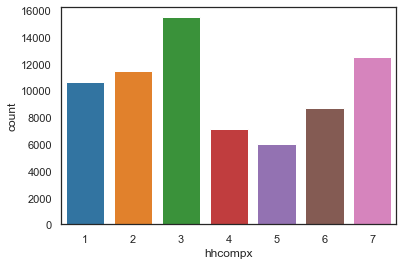

In [54]:
# Create chart to show number of values in hhcompx values 1 - 7
sns.countplot(x='hhcompx', data=df_exp)

The different categories are: 
- 1: Couple, no children, under 60, represents 14% of the dataset
- 2: Couple, no children, over 60, represents 16% of the dataset
- 3: Couple with dependent children, represents 21% of the dataset
- 4: Lone parent with dependent child, represents 10% of the dataset
- 5: Other multi-person households, represents 8% of the dataset
- 6: One person under 60, represents 12% of the dataset
- 7: One person 60 or over, represents 17% of the dataset

<AxesSubplot:xlabel='gorEHS', ylabel='count'>

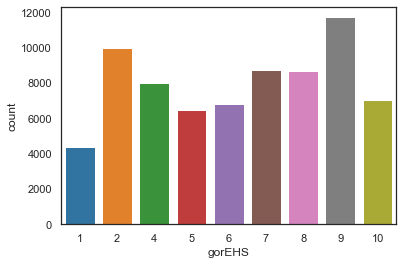

In [55]:
# Create chart to show number of values in gorEHS values 1 - 10
sns.countplot(x='gorEHS', data=df_exp)

Government Office Regions as per the English Housing Survey. This relates to the government office regions now abolished. They are North East, North West, Yorkshire and The Humber, East Midlands, West Midlands, East of England, London, South East, South West. It is not documented which number relates to which region in this dataset documentation or EHS.

<AxesSubplot:xlabel='FPEERband', ylabel='count'>

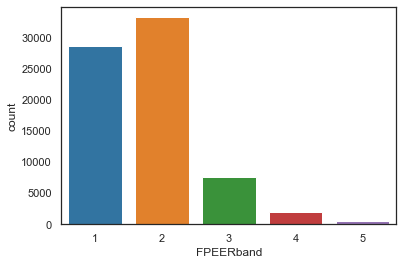

In [56]:
# Create chart to show number of values in FPEERband values 1 - 5
sns.countplot(x='FPEERband', data=df_exp)

This is the Fuel Poverty Energy Efficiency Rating Band. is a measure of the energy efficiency of a 
property based on the Standard Assessment Procedure (SAP) but accounts for policies that 
directly affect the cost of energy. Similar to SAP, the FPEER methodology generates a rating 
between 1 and 100, which is then translated into an energy efficiency Band from G (lowest) to 
A (highest). 

The bands are as follows:
FPEER band: SAP rating
- 1: A-C, represents 14% of the dataset
- 2: D, represents 16% of the dataset
- 3: E, represents 21% of the dataset
- 4: F, represents 9.87% of the dataset
- 5: G, represents 8.37% of the dataset

<AxesSubplot:xlabel='FullincDeciles', ylabel='count'>

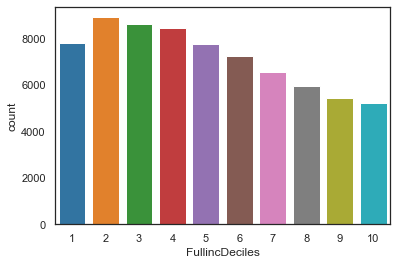

In [57]:
# Create chart to show number of values in FullincDeciles values 1 - 10
sns.countplot(x='FullincDeciles', data=df_exp)

- The first decile relates to the households with the lowest 10% of annual fuel poverty full incomes, represents 14% of the dataset.
- The tenth decile relates to the households with the highest 10% of annual fuel poverty full incomes. 
This varies by year.

<AxesSubplot:xlabel='fpflgf', ylabel='count'>

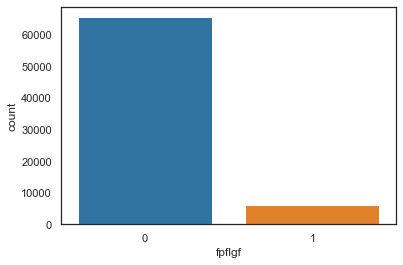

In [58]:
# Create chart to show number of values in fpflgf (Fuel poverty) values 0 and 1
sns.countplot(x='fpflgf', data=df_exp)

This graph helps us visalise the ration of households not in fuel poverty (0) and those that are in fuel poverty (1). While this does not inform our analysis at this point, it will have implications for model training as seen later.

<AxesSubplot:>

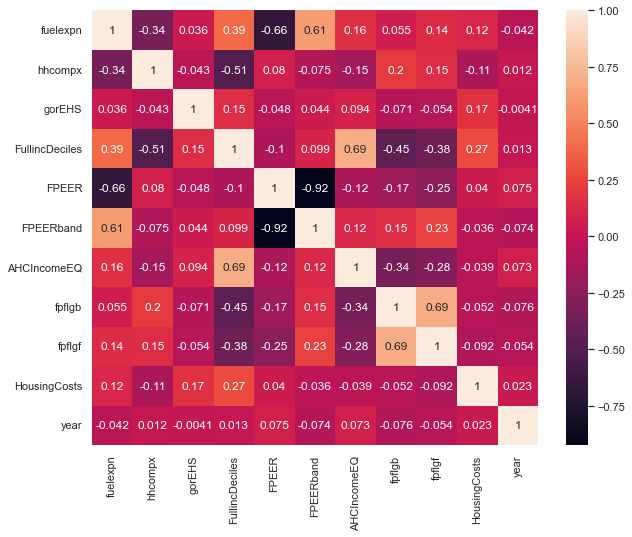

In [59]:
# build correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_exp.corr(),annot=True) 

As seeing correlations between variables in table form might be difficult to understand at a glance, a heatmap has been used as a visual aid. From this we can see that the strongest relationships tied to fpflgf is fpflgb (which is unsurprising as 'fpflgb' is the basic income so part of of fpflgf). Second to that, is the relationship between FPEERband and hhcompx, though these are significantly less important. Interestingly, there is an extremely weak relationship between fuel poverty (fpflgf) and fuel expenditure (fuelexpn), which is not especially surprising considering that if one is in fuel poverty, they are unlikely to be able to afford to increase expenditure on fuel.

In [60]:
# Remove any duplicated indexes in dataframe (necessary for following charts)
df_exp[df_exp.index.duplicated()]
df_exp= df_exp.loc[~df_exp.index.duplicated(), :]

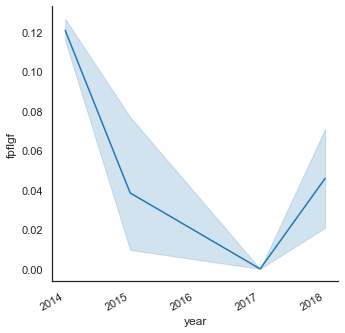

In [61]:
# Creates a line chart showing variation in fuel poverty flag (fpflgf) over years 2014 - 2015
df1 = pd.DataFrame(dict(time=np.arange(500),
                       value=np.random.randn(500).cumsum()))
g = sns.relplot(x="year", y="fpflgf", kind="line", data=df_exp)
g.figure.autofmt_xdate()

The chart above attempts to display a relationship between the presence of fuel poverty over time. 
</br>
Interestingly, we can see a sharp decrease in data poverty between 2014 and 2015, eventually reaching its' lowest levels in 2017, before sharply increasing to 2018.
</br> We do not have enough data to make accurate predictions at this stage, but a point for future investigation would be noticing the potential relationships that occur between COVID-19 related fuel expenditure increase and fuel poverty.

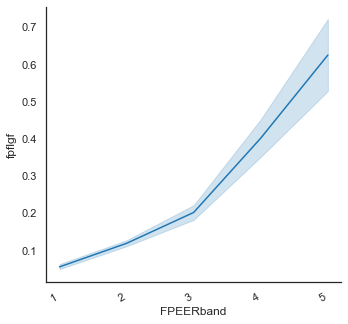

In [62]:
# Creates a line chart showing variation in fuel poverty flag (fpflgf) over FPEERband
df1 = pd.DataFrame(dict(time=np.arange(500),
                       value=np.random.randn(500).cumsum()))
g = sns.relplot(x="FPEERband", y="fpflgf", kind="line", data=df_exp)
g.figure.autofmt_xdate()

The chart above attempts to investigate a relationship between fuel poverty and the FPEERband of a given home. It is clear to see that as the energy efficiency of a home decreases, the likelihood of being in fuel poverty increases. 
</br>
The increase in fuel poverty that occurs between household efficiency levels A - E is not nearly as sharp as the increases that occur for household efficiency levels below that. 
</br>
This is likely explained by the different house maintenance performed by a home owner (who is more likely to have a better insulated, environmentally friendly home) and a renter. This is likely to have implications for landlords and leased accommodation, and represents an area for the government and local councils to focus on in order to further reduce fuel poverty in England.
</br>
Another potential explanation is that homes built prior to 2014 are more likely to be old and fail to meet current insulation regulations. This would lead to lots of heat wastage and pushing up fuel usage for the inhabitants.
</br>
This graph leads credence to the government directive to increase the amount of homes that fall between the household efficiency A - C ratings. It's clear to see that homes that fall outside of those ranges are far more likely to fall into fuel poverty at some stage in their tenancy.

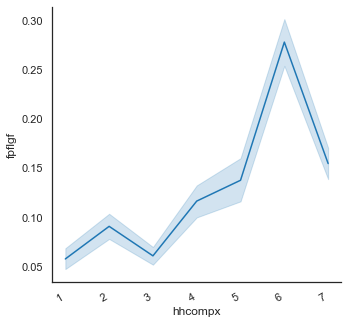

In [63]:
# Creates a line chart showing variation in fuel poverty flag (fpflgf) over hhcompx values
df1 = pd.DataFrame(dict(time=np.arange(500),
                       value=np.random.randn(500).cumsum()))
g = sns.relplot(x="hhcompx", y="fpflgf", kind="line", data=df_exp)
g.figure.autofmt_xdate()

This chart attempts to display the relationship between household composition and fuel poverty. 
</br>
Unsurprisingly, a couple under the age of 60 with no children and a couple with dependent children represent the demographic groups least likely to be in fuel poverty.
</br>
Interestingly, the demographic group most likely to be in fuel poverty is the single person household under the age of 60. It would be interesting to explore the potential relationship between individual age brackets contained in this demographic with regards to the chances of them falling into fuel poverty, so let's take a look at that next.

## Exploring the relationship between households and fuel poverty
### Author: Farha

fpflgf      0     1
year               
2014    10419  1432
2015    10763  1192
2016    10966   958
2017    11098   865
2018    11313   890
2019    11065   909


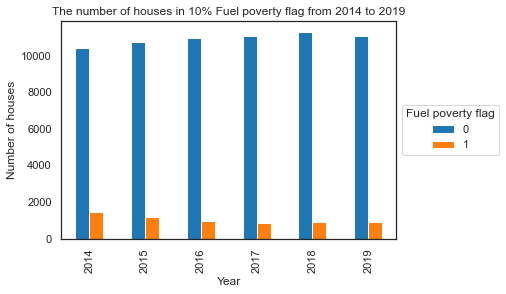

In [3]:
# Create sql query used to query database for data that will be charted
query1=pd.read_sql_query("SELECT f1.fpflgf, f1.year, COUNT(f1.fpflgf) AS count FROM fuel f1 GROUP BY f1.fpflgf, f1.year ORDER BY f1.year, f1.fpflgf;",conn)

# Define dataframe
df = pd.DataFrame(query1)

# Define dataframe pivot
df_pivot = pd.pivot_table(df, values='count', index='year', columns='fpflgf')

print(df_pivot)

# Define type of plot
fig = df_pivot.plot(kind = 'bar').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Year')
plt.ylabel('Number of houses')
plt.title('The number of houses in 10% Fuel poverty flag from 2014 to 2019')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Fuel poverty flag')
plt.show()


The graph above shows the number of houses that are in the fuel poverty flag. Where 1 indictes when a household is within the 10% fuel poverty flag and 0 indicates that the household is not within the 10% fuel poverty flag.

As the years have gone by less people are within the 10% fuel poverty flag and the number of people above the 10% has increased slowly.

There is a small dip within 2019 for hoseholds above the 10% fuel poverty flag and a small increase in the number of households within the fuel povery flag. A reason for this small change could be the result of COVID during the strat of 2019. This caused many people to lose jobs that required being within the building to carry out the work. As more people stayed at home during the day, when normally they would be at work/school etc, resulted in more households consuming more fuel thus raising the price of fuel.

fpflgf      0     1  percent of 0  percent of 1
year                                           
2014    10419  1432     87.916632     12.083368
2015    10763  1192     90.029276      9.970724
2016    10966   958     91.965783      8.034217
2017    11098   865     92.769372      7.230628
2018    11313   890     92.706711      7.293289
2019    11065   909     92.408552      7.591448


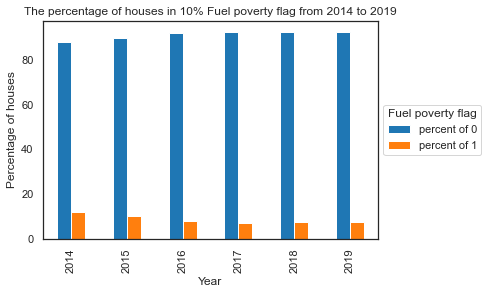

In [4]:
# Define df pivots for fuel poverty flags
df_pivot['percent of 0'] = (df_pivot[0] / (df_pivot[0] + df_pivot[1])) * 100
df_pivot['percent of 1'] = (df_pivot[1] / (df_pivot[0] + df_pivot[1])) * 100

print(df_pivot)

# Define type of plot
fig2 = df_pivot.plot(y=['percent of 0', 'percent of 1'], kind = 'bar').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Year')
plt.ylabel('Percentage of houses')
plt.title('The percentage of houses in 10% Fuel poverty flag from 2014 to 2019')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Fuel poverty flag')

plt.show()

The graph above shows the percentage of hosueholds that are within the 10% fuel poverty flag.

As the years have gone by less people are within the 10% fuel poverty flag and the number of people above the 10% has increased slowly.

There is a small dip within 2019 for hoseholds above the 10% fuel pverty flag and a small increase in the number of houselholds within the fuel povery flag. A reason for this small change could be the result of COVID during the strat of 2019. This caused many peopel to lose jobs that required being within the building to carry out the work. As more people satyed at home during the day, when normally they would be at work/school etc, resulted in more households consuming more fuel thus raising the price of fuel.


fpflgf     1
year        
2014    1432
2015    1192
2016     958
2017     865
2018     890
2019     909


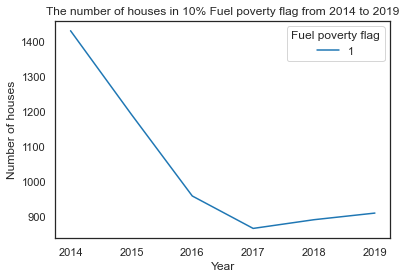

In [5]:
# Create sql query used to query database for data that will be charted
query2=pd.read_sql_query("SELECT f1.fpflgf, f1.year, COUNT(f1.fpflgf) AS count FROM fuel f1 GROUP BY f1.fpflgf, f1.year HAVING f1.fpflgf = 1 ORDER BY f1.year, f1.fpflgf;",conn)

# Define dataframe
df = pd.DataFrame(query2)

# Define dataframe pivot
df_pivot = pd.pivot_table(df, values='count', index='year', columns='fpflgf')

print(df_pivot)

# Define type of plot
fig3 = df_pivot.plot(y=[1], kind = 'line').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Year')
plt.ylabel('Number of houses')
plt.title('The number of houses in 10% Fuel poverty flag from 2014 to 2019')
plt.legend(title='Fuel poverty flag')

plt.show()

The graph above shows the number of houses that were within the 10% fuel poverty flag. As shown in the grapgh the number of houses that are in fuel poverty have decreases over the years.

There is a slight increase during 2018-2019 this could be due to fuel prices increasing and causing a strain for many households. This can aslo be due to COVID causing many people to lose jobs resulting in many household being pushed into fuel poverty.


FPEERband     1     2     3    4   5
year                                
2014       4243  5589  1557  372  90
2015       4693  5393  1427  348  94
2016       4453  5751  1309  313  98
2017       4431  5856  1258  327  91
2018       5117  5599  1119  290  78
2019       5684  5058   906  257  69


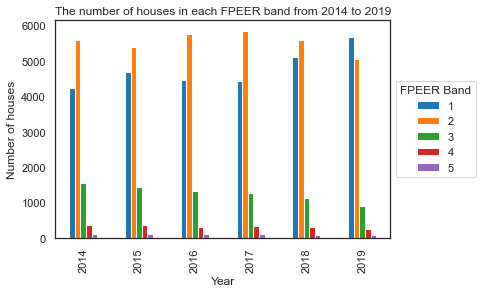

In [6]:
# Create sql query used to query database for data that will be charted
query3=pd.read_sql_query("SELECT f1.FPEERband, f1.year, COUNT(f1.FPEERband) AS count FROM fuel f1 GROUP BY f1.FPEERband, f1.year ORDER BY f1.year, f1.FPEERband;",conn)

# Define dataframe
df = pd.DataFrame(query3)

# Define dataframe pivot
df_pivot = pd.pivot_table(df, values='count', index='year', columns='FPEERband')

print(df_pivot)

# Define type of plot
fig3 = df_pivot.plot(kind = 'bar').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Year')
plt.ylabel('Number of houses')
plt.title('The number of houses in each FPEER band from 2014 to 2019')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='FPEER Band')

plt.show()

The graph shows the number of houses that are within each FPEER band through 2014 to 2019. The FPEER bands are 1 to 5, where 1 means the house has the best energy efficiency and 5 means the house has the worst energy efficiency. It is can be quite difficult for houses to recieve a band rating of 1 and so most houses fall between 2-3.

As shown in the bar graph above, houses are achieving more 1 and 2 band rating from 2014 to 2019. This shows more houses are being either built more energy efficient or exciting houses are redoing parts of their houses to ensure the house is more energy efficient.

In 2019, there is a large spike of teh number of houses that are within the 1 band rating. This can be explained by more people finding ways to ensure less fuel is used to heat homes by making exisitng home more energy efficient and so reduing fuel costs for hoseholds.

The number of houses recieving 3-5 band rating have decreased over the years showing that houses are now more energy efficient than they were before.


   FPEERband  totals
0          1   28621
1          2   33246
2          3    7576
3          4    1907
4          5     520


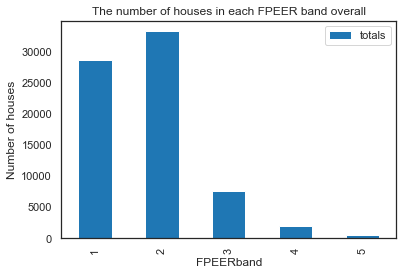

In [7]:
# Create sql query used to query database for data that will be charted
query4=pd.read_sql_query("SELECT f1.FPEERband, COUNT(f1.FPEERband) AS totals FROM fuel f1 GROUP BY f1.FPEERband;",conn)

print(query4)

# Define dataframe
df = pd.DataFrame(query4)

# Define type of plot
fig4 = df.plot(kind = 'bar', y='totals', x='FPEERband').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('FPEERband')
plt.ylabel('Number of houses')
plt.title('The number of houses in each FPEER band overall')

plt.show()

The bar graph shows the number of houses in each FPEER band for all years combined. As shown in the graph, the majority of the houses within the dataset have an FPEER band rating of 2 as the bar representing 2 is the highest. This second highest band is 1. This shows that a large majority of houses have a rating band of 1-2, this means that the houses are very energy effiecient.

There is a very small amount of houes that are in rating band 5, the reason houses may still be in the band could be old houses which are historically protected and so can not be redone to improve the energy effieciency of the houses. Could also be hoseholds that do not have a high income are unable to remodel their house to improve the band rating.


fpflgf   0   1
year          
2014    35  55
2015    41  53
2016    50  48
2017    45  46
2018    30  48
2019    29  40


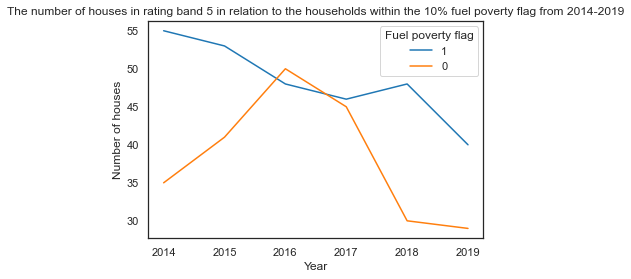

In [8]:
# Create sql query used to query database for data that will be charted
query5=pd.read_sql_query("SELECT f1.FPEERband, f1.fpflgf, f1.year, COUNT(f1.fpflgf) AS count FROM fuel f1 GROUP BY f1.fpflgf, f1.year,f1.FPEERband HAVING f1.FPEERband=5 ORDER BY f1.year, f1.fpflgf;",conn)

# Define dataframe
df = pd.DataFrame(query5)

# Define dataframe pivot
df_pivot = pd.pivot_table(df, values='count', index='year', columns='fpflgf')

print(df_pivot)

# Define type of plot
fig5 = df_pivot.plot(y=[1, 0], kind = 'line').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Year')
plt.ylabel('Number of houses')
plt.title('The number of houses in rating band 5 in relation to the households within the 10% fuel poverty flag from 2014-2019')
plt.legend(title='Fuel poverty flag')

plt.show()



The graph above shows the number of houses owned by households that are in and above the 10% fuel povery flag that have a house rating band of 5 each year.

As shown in the graph above the households within the fuel poverty flag have more houses in general that have a band rating of 5 than hosueholds that are above the fuel povery. This could be down to households having low income resulting in purchases of houses with poor FPEER band rating as they would be cheaper. Over the years, the number of households in fuel poverty with a rating band of 5 have decreased with the sharpest decrease being form 2018-2019.

However, there is a large increase of households above the fuel poverty having houses with band ratings of 5. This could be people buying cheap houses with poor band rating to renovate or demolish to build new houses with better band rating. This can be proven as the graph has a sharp decrease from 2016-2018 the number of houses with band rating of 5 owned by households above fuel poverty have decreased dramatically.


FPEERband     1
year           
2014       4243
2015       4693
2016       4453
2017       4431
2018       5117
2019       5684


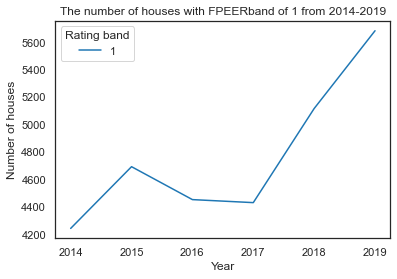

In [9]:
# Create sql query used to query database for data that will be charted
query6=pd.read_sql_query("SELECT f1.FPEERband, f1.year, COUNT(f1.FPEERband) AS count FROM fuel f1 GROUP BY f1.FPEERband, f1.year HAVING f1.FPEERband=1 ORDER BY f1.year, f1.FPEERband;",conn)

# Define dataframe
df = pd.DataFrame(query6)

# Define dataframe pivot
df_pivot = pd.pivot_table(df, values='count', index='year', columns='FPEERband')

print(df_pivot)

# Define type of plot
fig6 = df_pivot.plot(kind = 'line').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Year')
plt.ylabel('Number of houses')
plt.title('The number of houses with FPEERband of 1 from 2014-2019')
plt.legend(title='Rating band')

plt.show()



The graph shows the number of houses that have a rating band of 1 from 2014 to 2019. As shown in the graph, the number of houses that have the rating band of 1 increases through the years showing that the houses are getting more energy efficient. With the sharpest increase being from 2017-2019 this could be due to more focus done on increasing house energy effieciency as part of the givernment scheme.

The decrease between 2015-2017 could be explained as the government changed the requirements for a house to be within band 1 and this resulted in many houses not meeting the new requirements. That is why there could be a sharp increase later as households worked to improve their house energy efficiency to be within the new requirements.


FPEERband   5
year         
2014       90
2015       94
2016       98
2017       91
2018       78
2019       69


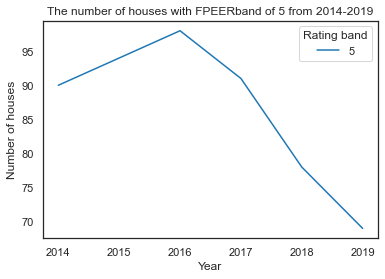

In [10]:
# Create sql query used to query database for data that will be charted
query7=pd.read_sql_query("SELECT f1.FPEERband, f1.year, COUNT(f1.FPEERband) AS count FROM fuel f1 GROUP BY f1.FPEERband, f1.year HAVING f1.FPEERband=5 ORDER BY f1.year, f1.FPEERband;",conn)

# Define dataframe
df = pd.DataFrame(query7)

# Define dataframe pivot
df_pivot = pd.pivot_table(df, values='count', index='year', columns='FPEERband')

print(df_pivot)

# Define type of plot
fig7 = df_pivot.plot(kind = 'line').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Year')
plt.ylabel('Number of houses')
plt.title('The number of houses with FPEERband of 5 from 2014-2019')
plt.legend(title='Rating band')

plt.show()



The graph above shows the number of houses that have an FPEER band rating of 5 from 2014 to 2019. As shown in the graph, the number of houses with a band rating of 5 have decreased over the years. This shows that more houses are becoming more energy efficient or newer houses being built are built more energy efficient.

There is a small increase form 2014-2016 this could be due to the fact many households were buying houses with poor rating bands as it would be cheaper. It could all be due to households not having enough income to improve the energy efficiency of their house.


FPEERband     1     2     3    4   5
year                                
2014       4243  5589  1557  372  90
2015       4693  5393  1427  348  94
2016       4453  5751  1309  313  98
2017       4431  5856  1258  327  91
2018       5117  5599  1119  290  78
2019       5684  5058   906  257  69


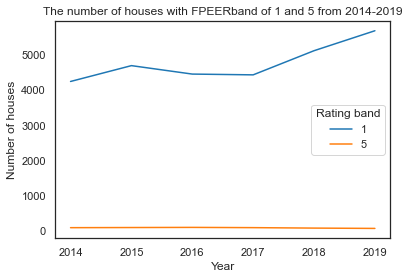

In [11]:
# Create sql query used to query database for data that will be charted
query8=pd.read_sql_query("SELECT f1.FPEERband, f1.year, COUNT(f1.FPEERband) AS count FROM fuel f1 GROUP BY f1.FPEERband, f1.year ORDER BY f1.year, f1.FPEERband;",conn)

# Define dataframe
df = pd.DataFrame(query8)

# Define dataframe pivot
df_pivot = pd.pivot_table(df, values='count', index='year', columns='FPEERband')

print(df_pivot)

# Define type of plot
fig8 = df_pivot.plot(y=[1,5], kind = 'line').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Year')
plt.ylabel('Number of houses')
plt.title('The number of houses with FPEERband of 1 and 5 from 2014-2019')
plt.legend(title='Rating band')

plt.show()



The graph shows the number of houses with band ratings of 1 and 5 from 2014-2019. The graph shows that majority of the houses have a rating band of 1 compared to rating band 5. This means more houses in gerenal are energy efficient and the houses are doing their best to improve their energy efficiency. The houses with rating band 5 have decreased over the years and the houses with rating band 1 has increased.


       FPEER
0      74.05
1      75.25
2      68.10
3      75.44
4      72.90
...      ...
71865  69.82
71866  68.97
71867  67.03
71868  72.03
71869  75.20

[71870 rows x 1 columns]


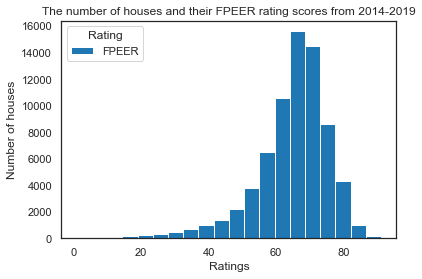

In [12]:
# Create sql query used to query database for data that will be charted
query9=pd.read_sql_query("SELECT f1.FPEER FROM fuel f1;",conn)

print(query9)

# Define dataframe
df = pd.DataFrame(query9)

# Define type of plot
fig9 = df.plot(kind = 'hist', bins=20).get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Ratings')
plt.ylabel('Number of houses')
plt.title('The number of houses and their FPEER rating scores from 2014-2019')
plt.legend(title='Rating')

plt.show()



The histogram shows the number of houses within certian FPEER ratings. As seen above, majority of the houses lie within the 60-80 ratings and very few lie below 20. This shows that many houses have good energy efficiency and are able to use less fuel to heat up homes and thus reuslting in lower fuel expenditure. The rating with the highest frequency woud be around 65-70 as shown in the histogram above.


   year  FuelExpenditure
0  2014      1296.109090
1  2015      1278.530429
2  2016      1217.958682
3  2017      1193.691489
4  2018      1220.308212
5  2019      1256.079351


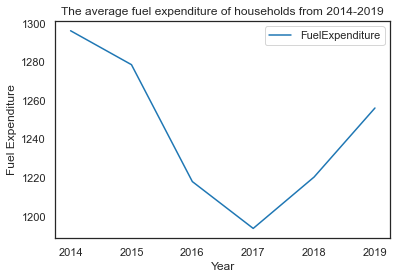

In [13]:
# Create sql query used to query database for data that will be charted
query10=pd.read_sql_query("SELECT f1.year, AVG(f1.fuelexpn) AS FuelExpenditure FROM fuel f1 GROUP BY f1.year ORDER BY f1.year, f1.fuelexpn;",conn)

# Define dataframe
df = pd.DataFrame(query10)

print(df)

# Define type of plot
fig10 = df.plot(y='FuelExpenditure', x='year', kind = 'line').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Year')
plt.ylabel('Fuel Expenditure')
plt.title('The average fuel expenditure of households from 2014-2019')

plt.show()



The graph shows the average fuel expenditure of houses from 2014-2019. As shown in the graph, there seems to be a decrease from years 2014-2017 and a sharp increase from 2017-2019.

The decrease can be the result of households improving their energy efficiencies of their homes. This will in turn result in less fuel being used to heat up homes and thus lowering fuel ependiture of households.

The increase can be explained by fuel costs increasing during the years as there could have been fuel shortages. This increase can also be attributed to many more people staying at home resulting in more fuel used during the day when otherwise it would not be used. This will cause households to have an increase in fuel expenditure.


   year  HousingCosts
0  2014   5145.516363
1  2015   5247.618974
2  2016   5360.413532
3  2017   5421.108403
4  2018   5451.558541
5  2019   5497.466174


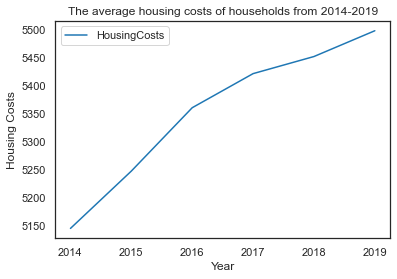

In [14]:
# Create sql query used to query database for data that will be charted
query11=pd.read_sql_query("SELECT f1.year, AVG(f1.HousingCosts) AS HousingCosts FROM fuel f1 GROUP BY f1.year ORDER BY f1.year, f1.HousingCosts;",conn)

# Define dataframe
df = pd.DataFrame(query11)

print(df)

# Define type of plot
fig11 = df.plot(y='HousingCosts', x='year', kind = 'line').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Year')
plt.ylabel('Housing Costs')
plt.title('The average housing costs of households from 2014-2019')

plt.show()



The graph above shows the average housing costs from 2014-2019. As shown in the graph, housing costs have increased over the years this is most likely the result of inflation. Housing costs in general increase over the years due to market value. This includes households that need to pay rent and pay mortgages.


   HousingCosts  FuelExpenditure  hhcompx
0   6639.454161      1282.025842        1
1   2054.642793      1350.247248        2
2   7866.219931      1509.427944        3
3   6444.913597      1260.367915        4
4   6507.458037      1342.521694        5
5   5301.005778       915.936362        6
6   3042.279823       954.874830        7


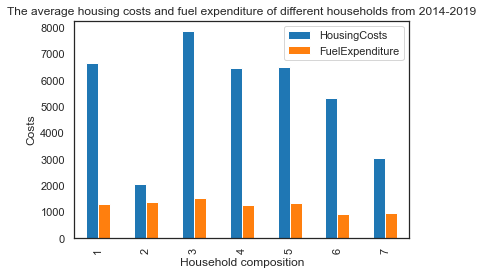

In [15]:
# Create sql query used to query database for data that will be charted
query12=pd.read_sql_query("SELECT AVG(f1.HousingCosts) AS HousingCosts, AVG(f1.fuelexpn) AS FuelExpenditure, f1.hhcompx FROM fuel f1 GROUP BY f1.hhcompx ORDER BY f1.hhcompx;",conn)

# Define dataframe
df = pd.DataFrame(query12)

print(df)

# Define type of plot
fig12 = df.plot(y=['HousingCosts', 'FuelExpenditure'], x='hhcompx', kind = 'bar').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Household composition')
plt.ylabel('Costs')
plt.title('The average housing costs and fuel expenditure of different households from 2014-2019')

plt.show()

The graph above shows the average fuel expenditure and average housing costs for each household. As shown on the graph the highest average housing costs and fuel expenditure were from households with a couple and dependent children. This household is represented by 3. This could be the result of many factors such as having children will need to having a bigger house to accommodate them, the bigger house will cost a lot. The fuel expenditure is also the largest for this household composition as more people living in a house results in more fuel being used to heat up the home.

The second highest would be households with housing composition of 1 who are couples with no children and are under 60. The average housing costs are still quite high, this could be because housing prices have increased during the years resulting in younger people struggling to find homes that are affordable to buy or to rent.

The lowest average housing costs are for a household composition of 2 who are couples with no children and over 60. This could be the result of the houses being purchased far earlier than 2014 when housing was far cheaper. This means the mortgage this household pays back is significantly less than the mortgage of couples far younger. Many of these couples could also have paid off their houses long ago and now only need to pay the running costs of the house such as fuel expenditure.

The lowest average fuel costs are for a household composition 6 which is a single person under 60. One person’s fuel usage and a family's fuel usage varies significantly. A person living on their own will not being using as much fuel as others, especially since they will be leaving home for the majority of the weekday to either go to university or work. This means the house does not need to be heated at those times resulting in a lower fuel expenditure.

## Household composition info.
### Author: Farha


   gorEHS  HousingCosts  FuelExpenditure
0       1   4001.701139      1184.720393
1       2   4278.975369      1230.582258
2       4   4237.936462      1235.915010
3       5   4277.405592      1256.379764
4       6   4408.304420      1273.163639
5       7   5348.404705      1243.459742
6       8   8920.732941      1177.347692
7       9   6354.159910      1269.429728
8      10   4832.926224      1306.820645


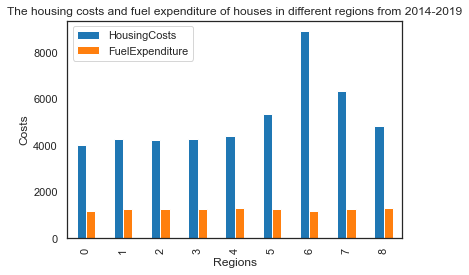

In [16]:
# Create sql query used to query database for data that will be charted
query13=pd.read_sql_query("SELECT f1.gorEHS, AVG(f1.HousingCosts) AS HousingCosts, AVG(f1.fuelexpn) AS FuelExpenditure FROM fuel f1 GROUP BY f1.gorEHS ORDER BY f1.gorEHS;",conn)

# Define dataframe
df = pd.DataFrame(query13)

print(df)

# Define type of plot
fig13 = df.plot(y= ['HousingCosts', 'FuelExpenditure'], kind = 'bar').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xlabel('Regions')
plt.ylabel('Costs')
plt.title('The housing costs and fuel expenditure of houses in different regions from 2014-2019')

plt.show()

The graph above shows the average housing costs and average fuel expenditure of houses in different regions in the UK from 2014 to 2019. The average fuel expenditure is very similar across the regions. The average housing costs seem to be quite large in region 8 compared to other regions and the lowest housing costs seem to be in region 1. Unfortunately, there is no documentation that describes the different gorEHS regions.

year            2014  2015  2016  2017  2018  2019
FullincDeciles                                    
1               1350  1281  1203  1262  1349  1347
2               1494  1494  1479  1495  1501  1448
3               1435  1470  1442  1382  1431  1451
4               1429  1441  1392  1393  1417  1374
5               1317  1308  1306  1280  1288  1246
6               1213  1175  1161  1227  1271  1198
7               1068  1097  1113  1125  1083  1055
8                957   988   982   966  1016  1028
9                822   887   948   924   935   925
10               766   814   898   909   912   902


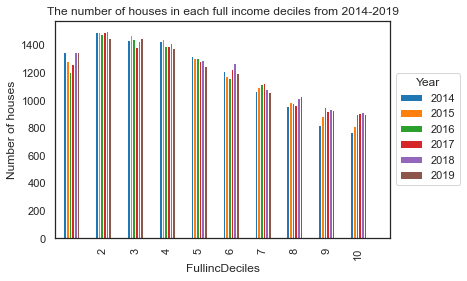

In [17]:
# Create sql query used to query database for data that will be charted
query14=pd.read_sql_query("SELECT f1.FullincDeciles, COUNT(f1.FullincDeciles) AS FullIncomeDeciles, f1.year FROM fuel f1 GROUP BY f1.year, f1.FullincDeciles ORDER BY f1.year, f1.FullincDeciles;",conn)

# Define dataframe
df = pd.DataFrame(query14)

# Define dataframe pivot
df_pivot = pd.pivot_table(df, values='FullIncomeDeciles', index='FullincDeciles', columns='year')

print(df_pivot)

# Define type of plot
fig14 = df_pivot.plot(kind = 'bar').get_figure()

# Assign labels, title and legend to plot and then show diagram
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Year')
plt.title('The number of houses in each full income deciles from 2014-2019')
plt.ylabel('Number of houses')

plt.show()

The graph above shows the number of houses in each full income decile for each year from 2014-2019. As shown in the graph the majority of households seem to be in 2nd decile which is quite low as the first decile represents the number of households in the 10% fuel poverty. As seen the number of households within the first decile has fluctuated over the years. The tenth decile has the lowest number of households overall, this is understandable as this decile contains households with the highest 10% annual income.

## Prevalence of Fuel Poverty:

### Author: Amea

In [35]:
# Calculate percentage of sample data in fuel poverty.
df_exp.fpflgf.value_counts()/df_exp.shape[0]

0    0.881423
1    0.118577
Name: fpflgf, dtype: float64

The numbers above answer the question: What share of the sample is in fuel poverty? </br>
From this it is clear to see that approximately 8% of the representitive sample is in fuel poverty.

In [37]:
# Read data from 2019 file only
df_2019 = pd.read_csv("data/processed/2019.csv")

# Calculate flfpgf as percentage of 2019 dataset
df_2019.fpflgf.value_counts()/df_2019.shape[0]

0    0.924086
1    0.075914
Name: fpflgf, dtype: float64

How does that compare to the current 2019 sample?</br>
It is about the same share, around 8% of the population, so little different from the aggregate.

In [38]:
# Create a frequency table of FullincDeciles and FPEERband for 2019 only
pd.crosstab(df_2019.FullincDeciles, df_2019.FPEERband)

FPEERband,1,2,3,4,5
FullincDeciles,,,,,
1,719,489,100,34,5
2,760,550,99,32,7
3,745,576,91,29,10
4,638,602,96,30,8
5,573,550,100,17,6
6,566,499,84,36,13
7,461,478,89,23,4
8,473,449,82,16,8
9,380,456,71,14,4


Those in the lowest decile are surprisingly concentrated in energy efficient dwellings (category 1) or one rating category below. It is encouraging to see, because this indicates that minor improvement could be made to a dwelling in order to reach the government mandate of all dwellings to be C rated or above by 2025. The distribution is also the same in all of the higher deciles.  

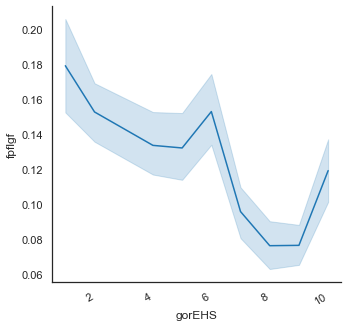

In [64]:
# Creates a line chart showing variation in fuel poverty flag (fpflgf) my region (gorEHS)
df1 = pd.DataFrame(dict(time=np.arange(500),
                       value=np.random.randn(500).cumsum()))
g = sns.relplot(x="gorEHS", y="fpflgf", kind="line", data=df_exp)
g.figure.autofmt_xdate()

Though we are unable to know precisely which region of England is represented by the numeric values above, it is clear to see that some regions are more likely to have increased levels of fuel poverty. Namely region 1 and 6. The environmental factors in these regions are more likely to be harsher and colder than the other regions. In addition to this, these areas could also consist of older properties, build before modern insulation building requirements.

In [40]:
# Create a frequency table of FullincDeciles and fpflgf for master data file
pd.crosstab(df_exp.FullincDeciles, df_exp.fpflgf)

fpflgf,0,1
FullincDeciles,,
1,481,892
2,1231,295
3,1325,156
4,1412,60
5,1326,30
6,1235,9
7,1094,3
8,1002,0
9,850,1


Is fuel poverty simply a low income phenomenon?
More than half of lowest income decile experiences fuel poverty. But not just a low income phenomenon it does also occur in the highest decile. It is interesting to see that the incidence of fuel poverty falls dramatically as income increases. This may reflect that the income elasticity of fuel is fairly low (i.e. more income doesn't mean you spend more on energy.)

In [41]:
# create a frequency table of FPEERband and fpflgf for master data file
pd.crosstab(df_exp.FPEERband, df_exp.fpflgf)

fpflgf,0,1
FPEERband,,
1,4152,240
2,5066,677
3,1277,321
4,226,151
5,35,58


The vast majority have a high rating, but even those living in energy efficient houses still could experience fuel poverty (around 3%). It is interesting to note that the probability of an household being in fuel poverty increases rapidly as the rating band decreases (i.e. energy efficiency falls). For occupants of rating band 3, 16% are in fuel poverty and in the lowest rating 5 it is 50%. 

## Data preparation for Modelling
### Auth: Amea

In [65]:
# Reading in data
df_train = pd.read_csv("data/dataset/train.csv")
df_test = pd.read_csv("data/dataset/test.csv")

# Restricting data to the bottom decile
df_train1 = df_train[df_train['FullincDeciles']==1]
df_test1 = df_test[df_test['FullincDeciles']==1]

# Checking for null values
df_train_n = df_train.info()
df_test_n = df_test.info()

# Returning null values
print(df_train_n)
print(df_test_n)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57504 entries, 0 to 57503
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      57504 non-null  int64  
 1   fuelexpn        57504 non-null  float64
 2   hhcompx         57504 non-null  int64  
 3   gorEHS          57504 non-null  int64  
 4   FullincDeciles  57504 non-null  int64  
 5   FPEER           57504 non-null  float64
 6   FPEERband       57504 non-null  int64  
 7   AHCIncomeEQ     57504 non-null  float64
 8   fpflgb          57504 non-null  int64  
 9   fpflgf          57504 non-null  int64  
 10  HousingCosts    57504 non-null  float64
 11  yr14            57504 non-null  int64  
 12  yr15            57504 non-null  int64  
 13  yr16            57504 non-null  int64  
 14  yr17            57504 non-null  int64  
 15  yr18            57504 non-null  int64  
 16  yr19            57504 non-null  int64  
 17  year            57504 non-null 

In [77]:
# Drop unnecessary varaibles
df_dt = df_train.drop(['Unnamed: 0','fuelexpn','FPEER','AHCIncomeEQ', 'fpflgb', 'HousingCosts', 'year','split', ], axis=1)
df_dtt = df_test.drop(['Unnamed: 0','fuelexpn','FPEER','AHCIncomeEQ', 'fpflgb', 'HousingCosts', 'year','split'], axis=1)
df_dt1 = df_train1.drop(['Unnamed: 0','fuelexpn','FPEER','fpflgb', 'HousingCosts', 'year','split','FullincDeciles' ], axis=1)
df_dtt1 = df_test1.drop(['Unnamed: 0','fuelexpn','FPEER','FullincDeciles', 'fpflgb', 'HousingCosts', 'year','split'], axis=1)

df_dt = df_dt[df_dt.columns.drop(list(df_dt.filter(regex='yr')))]
df_dtt = df_dtt[df_dtt.columns.drop(list(df_dtt.filter(regex='yr')))]
df_dt1 = df_dt1[df_dt1.columns.drop(list(df_dt1.filter(regex='yr')))]
df_dtt1 = df_dtt1[df_dtt1.columns.drop(list(df_dtt1.filter(regex='yr')))]

In [81]:
# Check the ratio of positive to negative values
ch_dt = df_dt['fpflgf'].value_counts()/len(df_dt['fpflgf'])
ch_dtt = df_dtt['fpflgf'].value_counts()/len(df_dtt['fpflgf'])
ch_dt1 = df_dt1['fpflgf'].value_counts()/len(df_dt1['fpflgf'])
ch_dtt1 = df_dtt1['fpflgf'].value_counts()/len(df_dtt1['fpflgf'])

print(ch_dt)
print(ch_dtt)
print(ch_dt1)
print(ch_dtt1)

0    0.912267
1    0.087733
Name: fpflgf, dtype: float64
0    0.9164
1    0.0836
Name: fpflgf, dtype: float64
1    0.533728
0    0.466272
Name: fpflgf, dtype: float64
1    0.531901
0    0.468099
Name: fpflgf, dtype: float64


The test and train data have the same ratio which is good news! 8% fuel poverty rate same as the master. The restricted dataset which we will use later shows the same fuel poverty rate for the test and train which is 53%.

In [82]:
# Set up the dependent and independent variables:
X_train = df_dt.drop('fpflgf', axis=1)
Y_train = df_dt['fpflgf']

X_test = df_dtt.drop('fpflgf', axis=1)
Y_test = df_dtt['fpflgf']

X_train1 = df_dt1.drop('fpflgf', axis=1)
Y_train1 = df_dt1['fpflgf']

X_test1 = df_dtt1.drop('fpflgf', axis=1)
Y_test1 = df_dtt1['fpflgf']

# Define train and test target values
train_target = df_dt['fpflgf']
test_target = df_dtt['fpflgf']

In [83]:
# Prettify confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          axis=1,
                          figsize=(5,4), 
                          fontsize=14,
                          cmap='Blues'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Note that normalization here by default occurs across axis=1, or across each row (true class). 
    """
    
    if normalize:
        if axis == 1:
            cm = cm.astype('float') / cm.sum(axis=axis)[:, np.newaxis] * 100
        elif axis == 0:
            cm = cm.astype('float') / cm.sum(axis=axis)[np.newaxis, :] * 100
        else:
            raise ValueError("axis must be 0 or 1")
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig = plt.figure(figsize=figsize)
    plt.grid(b=None)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    q_labels = ['TN', 'FP', 'FN', 'TP']
    quad_font_size = 14
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    q_i = 0
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        
        q = plt.text(j, i-0.2, q_labels[q_i], horizontalalignment='center', fontsize=quad_font_size)
        q_i += 1
        q.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='white'))
        
        t = plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                     verticalalignment="center",
                 color="#002781",
                    fontsize=fontsize)
        t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='white'))
        

    plt.tight_layout(h_pad=10, w_pad=0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

## Model 1: Decision Tree

### Author: Amea

In [84]:
# Decision Tree Classifier model


clf = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=20, 
                             min_samples_leaf=10, max_features=None)

# Fit your Decision Tree model to your train model
clf.fit(X_train, Y_train)

# Predict labels on your Test set of independent variables
pred_clf = clf.predict(X_test)

# Predict probabilities on your Test set of independent variables
proba_clf = clf.predict_proba(X_test)

In [85]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, pred_clf))

Accuracy: 0.9526660169845469


The accuracy of the decision tree model is 95%, which is not bad at all.

In [86]:
# Let's see how it performs at getting a positive/negative outcome right:
print(metrics.confusion_matrix(Y_test, pred_clf))
# https://python-course.eu/machine-learning/confusion-matrix-in-machine-learning.php#:~:text=A%20confusion%20matrix%20is%20a,instances%20of%20a%20predicted%20class

[[12920   245]
 [  435   766]]


At first glance this looks great! The model is accurately predicting really well!

In [87]:
# Checking positive prediction accuracy
print(metrics.classification_report(Y_test, pred_clf))

auc = metrics.roc_auc_score(Y_test, proba_clf[:,1])
print("AUC: ",auc)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     13165
           1       0.76      0.64      0.69      1201

    accuracy                           0.95     14366
   macro avg       0.86      0.81      0.83     14366
weighted avg       0.95      0.95      0.95     14366

AUC:  0.9706352125222903


Let's see how the it goes at accurately predicting what is positive:
</br>This table puts the confusion matrix into perspective: 
</br>The model accurately identifies 76% of those actually sufferring from fuel poverty, but of those it casts as in fuel poverty, it only correct 64% of the time.
</br>The model accurately identifies 97% of those actually not sufferring from fuel poverty, and of those it casts as not sufferring from fuel poverty it is correct 98% of the time.
</br>What this means is that it is quite a lot better at identifying those not in fuel poverty than those who are. Hence, if this model was implemented for government policies, it would likely face criticism of not helping those in need and incorrectly giving to benefit fraudsters.

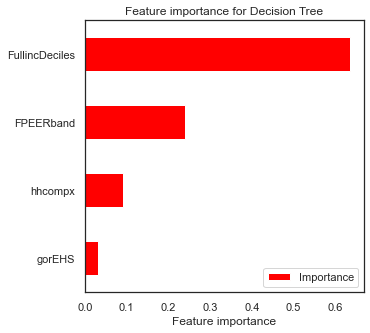

In [88]:
# Plot of feature importance list to visualise key features that contribute to the model preditions:
features_log = pd.DataFrame(clf.feature_importances_, index = X_train.columns.tolist(), 
                            columns = ['Importance'])
features_log = features_log.sort_values(by = 'Importance', ascending = True)

features_log.plot(kind='barh', figsize=(5, 5), color = "red")
plt.xlabel('Feature importance')
plt.title('Feature importance for Decision Tree')
plt.show()

How much of a surprise is this? Given that we know from the cross tab that a large percentage of those in fuel poverty are in the lowest decile, it's obvious that this is a strong predictor. However it's encouraging to know that the FPEER bands are strong predictors and it's not just about income. The other features which would be contributing to the fuel expenditure calculation don't contribute very much and it appears the denominator 'dominates'. 
</br>
Given this result, it is worthwhile looking at the lowest decile alone and seeing if we can improve the accuracy to the benefit of those who are really sufferring.

###   Decision tree model of the lowest decile:

In [89]:
# Decision Tree Classifier model with Decile 1 restriction
clf1 = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=20, 
                             min_samples_leaf=10, max_features=None)

# Fit your Decision Tree model to your train model
clf1.fit(X_train1, Y_train1)

# Predict labels on your Test set of independent variables
pred_clf1 = clf1.predict(X_test1)

# Predict probabilities on your Test set of independent variables
proba_clf1 = clf1.predict_proba(X_test1)

print("Accuracy:",metrics.accuracy_score(Y_test1, pred_clf1))

Accuracy: 0.783203125


The accuracy has dropped to approximately 78%, but this may not be indicative of the true power of the model.

In [90]:
# Construct confusion matrix for restricted model
print(metrics.confusion_matrix(Y_test1, pred_clf1))

[[554 165]
 [168 649]]


In [91]:
# Construct classification report for restricted model
print(metrics.classification_report(Y_test1, pred_clf1))

auc = metrics.roc_auc_score(Y_test1, proba_clf1[:,1])
print("AUC: ",auc)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       719
           1       0.80      0.79      0.80       817

    accuracy                           0.78      1536
   macro avg       0.78      0.78      0.78      1536
weighted avg       0.78      0.78      0.78      1536

AUC:  0.8819572948284287


This is a considerable improvement when it comes to those in fuel poverty (which really is the purpose of this model). By focusing solely on the lowest decile, the model accurately identifies 79% of those actually sufferring from fuel poverty (as opposed from 76%), and of those it casts as being fuel poverty, it is correct 80% of the time (vs 64% previously).

When it comes to identifying those not sufferring from fuel poverty it doesn't perform as well. It accurately identifies 77% (vs 97% in the full model) of those actually not sufferring from fuel poverty, and of those it casts as not sufferring fuel poverty it is correct 77% of the time (vs. 98%).

This is a better model than the former for accurately identifying to help those in fuel poverty. There is much less likelyhood of overlooking someone in need and considerably less likelihood of benefit fraud taking place.

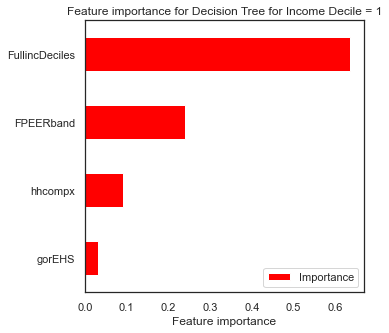

In [92]:
# Plot of feature importance list to visualise key features that contribute to the model preditions:
features_log1 = pd.DataFrame(clf1.feature_importances_, index = X_test1.columns.tolist(), 
                            columns = ['Importance'])
features_log1 = features_log.sort_values(by = 'Importance', ascending = True)

features_log1.plot(kind='barh', figsize=(5, 5), color = "red")
plt.xlabel('Feature importance')
plt.title('Feature importance for Decision Tree for Income Decile = 1')
plt.show()

Income is again by far the most important, but only explains ~50% this time. The energy efficiency rating is a far more important factor for determining fuel poverty in the lowest decile, 35% verses around 25% previously. Interestingly the region becomes more important (around 10% vs around 5%) but household composition becomes less (5% vs ~10% in the whole sample). Region could be capturing some of same effects as income, with concentrations of the lowest decile higher in some regions than others.

## Model 2: Logistic Regression
### Author: Hazel

In [93]:
# Logistic regression
clf_logit = LogisticRegression()
clf_logit.fit(X_train, Y_train)
pred_clf_logit = clf_logit.predict(X_test)
proba_clf_logit = clf_logit.predict_proba(X_test)

In [94]:
# Return probabilities associated with labels 0 and 1, respectively
print(proba_clf_logit)

[[9.81499529e-01 1.85004706e-02]
 [9.99999733e-01 2.67234421e-07]
 [3.66443860e-01 6.33556140e-01]
 ...
 [6.64632339e-01 3.35367661e-01]
 [9.32295340e-01 6.77046604e-02]
 [2.66891119e-01 7.33108881e-01]]


In [95]:
# Setting thresholds
thres = 0.5
target_predict_logit = np.where(proba_clf_logit[:,1] > thres, 1, 0)
target_actual = Y_test

In [96]:
# Return positive cases in train/test data
train_pos_count = Y_train.sum()
test_pos_count = Y_test.sum()

# Prints these percentages to screen
print('% positive in train set (count/total): {:.2f}% ({}/{})'
      .format(train_pos_count * 100.0 / len(Y_train), train_pos_count, len(Y_train)))
print('% positive in test set (count/total): {:.2f}% ({}/{})'
      .format(test_pos_count * 100.0 / len(Y_test), test_pos_count, len(Y_test)))

% positive in train set (count/total): 8.77% (5045/57504)
% positive in test set (count/total): 8.36% (1201/14366)


In [97]:
# Return number positive cases predicted with logistic regression

logit_pos_count = target_predict_logit.sum()
print('% positive in logistic predictions (count/total): {:.2f}% ({}/{})'
      .format(logit_pos_count * 100.0 / len(Y_test), logit_pos_count, len(Y_test)))

% positive in logistic predictions (count/total): 7.26% (1043/14366)


Confusion matrix, without normalization
[[12871   294]
 [  452   749]]
Normalized confusion matrix
[[97.76680592  2.23319408]
 [37.63530391 62.36469609]]


<Figure size 432x288 with 0 Axes>

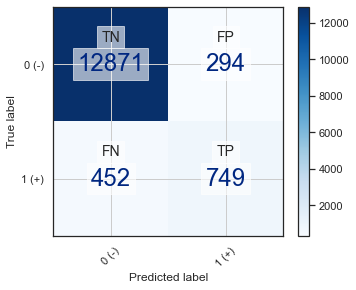

<Figure size 432x288 with 0 Axes>

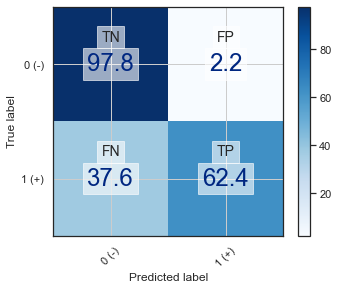

<Figure size 432x288 with 0 Axes>

In [98]:
# Settings for confusion matrix
class_names = ['0 (-)', '1 (+)']
fontsize=24
figsize=(5,4)

# Plot the confusion matrix of the logistic regression
logit_cfn = confusion_matrix(target_actual, target_predict_logit)
log_tn, log_fn, log_fp, log_tp = confusion_matrix(target_actual, target_predict_logit).ravel()


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(logit_cfn, classes=class_names, 
                      normalize=False, figsize=figsize, fontsize=fontsize)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(logit_cfn, classes=class_names, 
                      normalize=True, figsize=figsize, fontsize=fontsize)

plt.show()
plt.tight_layout()

In [99]:
# Calculate and print accuracy of logistic regression
log_acc = round((log_tp + log_tn) / X_test.shape[0], 3) * 100
print('Logistic regression accuracy: {:.2f}%'.format(log_acc))

# Calculate and return precision of logistic regression
log_precision = round((log_tp / (log_tp + log_fp)), 2) * 100
print('Logistic regression precision: {:.2f}%'.format(log_precision))

Logistic regression accuracy: 94.80%
Logistic regression precision: 62.00%


The accuracy of the logistic regression is 95% which is quite high. Disappointingly the logistic regression precision is 60% which means that the model is only slightly more likely to produce positive predictions.

In [100]:
# Construct confusion matrix for logstic regression
print(metrics.confusion_matrix(Y_test, pred_clf_logit))

[[12871   294]
 [  452   749]]


The quadrants of the confusion matrix are: </br>
    True negative, False positive
    </br>
    False negative, True positive
    </br>
    
Being aware of this, it is clear to see that our true negative values vastly outweigh the false negative values. This means the model is quite likely to predict those not in fuel poverty.</br>
In addition to this, our true positive values outweigh our false positive values, however the ratio could be better. This means that the model can predict values in fuel poverty, but it is not as certain as the other prediction.

In [101]:
# Print classification report for logistic regression model
print(metrics.classification_report(Y_test, pred_clf_logit))

auc = metrics.roc_auc_score(Y_test, proba_clf_logit[:,1])
print("AUC: ", auc)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     13165
           1       0.72      0.62      0.67      1201

    accuracy                           0.95     14366
   macro avg       0.84      0.80      0.82     14366
weighted avg       0.95      0.95      0.95     14366

AUC:  0.9630125294372679


The support values represent the number of occurrences of the given values (0, 1 of fpflgf) in the dataset. As it is clear to see, the data set is quite imbalanced. It is important, then, to look at the precision and recall values in order to better evaluate an imbalanced dataset. This is because a high accuracy in an imbalanced data set does not carry a huge amount of value - it has been trained on extremely biased data.
</br>
Thus, the precision and recall values are what we will examine next. The precision values of 0.96 and 0.75 represent how good our model is when the prediction is positive. This means that it is extremely confident in predicting when a data point is likely to fall in the 'not in fuel poverty' category, however it is a lot less confident when predicting whether a data point represents the 'in fuel poverty category'. This makes sense as our data set is imbalanced. However, the 75% represents a fairly confident model. This is in contrast with the recall values - which measures how well our model can predict positive values. This number is only 60% - this is still above half, but not as high as it could be. There are many reasons for this, but it is most likely due to an insufficient quantity of positive data.

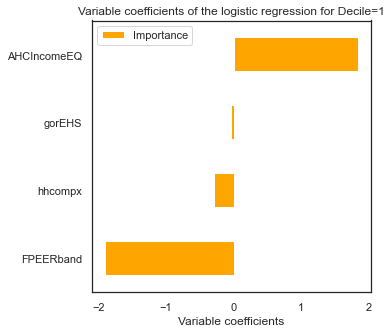

In [102]:
# Calculate feature importance
coefs = pd.DataFrame(clf_logit.coef_.reshape((4, 1)), 
                         index = X_train1.columns.tolist(), columns = ['Importance'])
coefs = coefs.sort_values(by='Importance', ascending=True)
coefs.plot(kind='barh', figsize=(5,5), color = 'orange')
plt.xlabel('Variable coefficients')
plt.title('Variable coefficients of the logistic regression for Decile=1')
plt.show()

The coefficients are no surprise: a negative relationship with income decile and positive with FPEER band (i.e. the smaller your income or the higher the energy efficiency band, 5 being the lowest, the more likely you are to be in fuel poverty).

###   Logistic regression model of the lowest decile:

We are going to investigate what changes (if any) restricting the model to functioning on the lowest decile only as these are the sample with the highest prevalence of fuel poverty.

In [103]:
# Logistic regression
clf_logit1 = LogisticRegression()
clf_logit1.fit(X_train1, Y_train1)
pred_clf_logit1 = clf_logit1.predict(X_test1)
proba_clf_logit1 = clf_logit1.predict_proba(X_test1)

In [104]:
# Return probabilities associated with labels 0 and 1, respectively
print(proba_clf_logit1)

[[0.1577122  0.8422878 ]
 [0.76627434 0.23372566]
 [0.08369553 0.91630447]
 ...
 [0.74376512 0.25623488]
 [0.84697544 0.15302456]
 [0.2081845  0.7918155 ]]


In [105]:
# Setting thresholds
thres1 = 0.5
target_predict_logit1 = np.where(proba_clf_logit1[:,1] > thres, 1, 0)
target_actual1 = Y_test1

In [106]:
# Return positive cases in train/test data
train_pos_count1 = Y_train1.sum()
test_pos_count1 = Y_test1.sum()

# Prints these percentages to screen
print('% positive in train set (count/total): {:.2f}% ({}/{})'
      .format(train_pos_count1 * 100.0 / len(Y_train1), train_pos_count1, len(Y_train1)))
print('% positive in test set (count/total): {:.2f}% ({}/{})'
      .format(test_pos_count1 * 100.0 / len(Y_test1), test_pos_count1, len(Y_test1)))

% positive in train set (count/total): 53.37% (3339/6256)
% positive in test set (count/total): 53.19% (817/1536)


In stark contrast to the unrestricted data, this dataset is far more balanced.

In [107]:
# Return number positive cases predicted with logistic regression
logit_pos_count1 = target_predict_logit1.sum()
print('% positive in logistic predictions (count/total): {:.2f}% ({}/{})'
      .format(logit_pos_count1 * 100.0 / len(Y_test1), logit_pos_count1, len(Y_test1)))

% positive in logistic predictions (count/total): 52.47% (806/1536)


Again, the % positive in logistic predictions is approximately 50% - a huge increase from the previously represented value.

Confusion matrix, without normalization
[[12871   294]
 [  452   749]]
Normalized confusion matrix
[[97.76680592  2.23319408]
 [37.63530391 62.36469609]]


<Figure size 432x288 with 0 Axes>

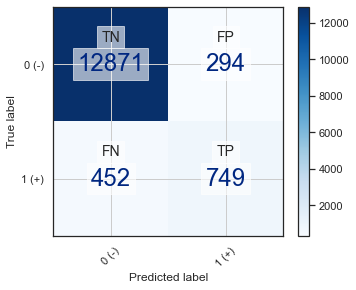

<Figure size 432x288 with 0 Axes>

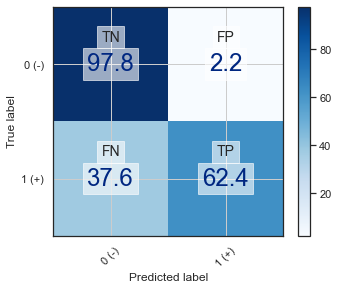

<Figure size 432x288 with 0 Axes>

In [108]:
# Settings for confusion matrix
class_names = ['0 (-)', '1 (+)']
fontsize=24
figsize=(5,4)

# Plot the confusion matrix of the logistic regression
logit_cfn1 = confusion_matrix(target_actual1, target_predict_logit1)
log_tn1, log_fn1, log_fp1, log_tp1 = confusion_matrix(target_actual1, target_predict_logit1).ravel()


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(logit_cfn, classes=class_names, 
                      normalize=False, figsize=figsize, fontsize=fontsize)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(logit_cfn, classes=class_names, 
                      normalize=True, figsize=figsize, fontsize=fontsize)

plt.show()
plt.tight_layout()

In [109]:
# Calculate and print accuracy of logistic regression
log_acc1 = round((log_tp1 + log_tn1) / X_test1.shape[0], 3) * 100
print('Logistic regression accuracy: {:.2f}%'.format(log_acc1))

# Calculate and return precision of logistic regression
log_precision1 = round((log_tp1 / (log_tp1 + log_fp1)), 2) * 100
print('Logistic regression precision: {:.2f}%'.format(log_precision1))


Logistic regression accuracy: 76.40%
Logistic regression precision: 77.00%


Again, more contrasts to the unrestricted data set. This time the logistic regression accuracy has dropped to 76%. Though at first glance this seems to be disappointing, it actually means that the model is more likely to have learned in a less biased way than the first model.
</br>
The logsitic regression precision has slightly increased to a value similar to the accuracy. 

In [110]:
# Construct confusion matrix for logstic regression
print(metrics.confusion_matrix(Y_test1, pred_clf_logit1))

[[543 176]
 [187 630]]


This time we see that our true negative values still outweigh the false negative values. This means the model is still quite likely to predict those not in fuel poverty.</br>
In contrast to the previous dataset, our true positive values outweigh our false positive values in a similar ratio to the true negative values:false negative values. This might mean that the model is going to be a better predictor than the previous one. In order to check this, let's check the values produced by the classification report.

In [111]:
# Print classification report for logistic regression model
print(metrics.classification_report(Y_test1, pred_clf_logit1))

auc = metrics.roc_auc_score(Y_test1, proba_clf_logit1[:,1])
print("AUC: ", auc)

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       719
           1       0.78      0.77      0.78       817

    accuracy                           0.76      1536
   macro avg       0.76      0.76      0.76      1536
weighted avg       0.76      0.76      0.76      1536

AUC:  0.8476957831068923


The support values represent the number of occurrences of the given values (0, 1 of fpflgf) in the dataset. It is extremely clear to see that this dataset is far more balanced than the previous one. This is good news as it means that any predictions made are far less likely to be excessevely biased and more likely to predict accurate predictions.
</br>
Looking at the precision and recall values. The precision values of 0.74 and 0.78 represent how good our model is when the prediction is positive. This means that it is less confident than the previous one, when a data point is likely to fall in the 'not in fuel poverty' category. It has a similar level of confidence when predicting whether a data point represents the 'in fuel poverty category'. 
</br>
This makes sense as our data set is balanced. Depending on the acceptable threshold set, 74% is a low but mostly reliable model (78% being a more reliable model than that). 
</br> 
A a glance it seems like this model performs to a lower standard than previous models, taking all of the variables in hand this model is more likely to be reliable than the previous one.

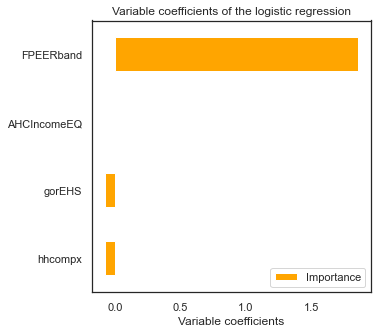

In [113]:
# Plotting the features and their score in ascending order
coefs = pd.DataFrame(clf_logit1.coef_.reshape((4, 1)), 
                         index = X_train1.columns.tolist(), columns = ['Importance'])
coefs = coefs.sort_values(by='Importance', ascending=True)
coefs.plot(kind='barh', figsize=(5,5), color = 'orange')
plt.xlabel('Variable coefficients')
plt.title('Variable coefficients of the logistic regression')
plt.show()

The logistic regression determines that income carries no weight at all, and the energy efficiency rating coefficient remains the same. This is encouraging as it implies that the government policy to raise the energy efficiency of all houses to C rating or more would be effective in reducing fuel poverty.

## Model 3: Random Forest

In [114]:
# Random forest 
clf_rf = RandomForestClassifier(random_state = 33, n_estimators=50, max_depth=5, 
                                min_samples_leaf=30, max_features=4)
clf_rf.fit(X_train, Y_train)
pred_clf_rf = clf_rf.predict(X_test)
proba_clf_rf = clf_rf.predict_proba(X_test)

In [115]:
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test, pred_clf_rf))

Accuracy: 0.9519003202004733


In [116]:
# Construct confusion matrix for Random forest
print(metrics.confusion_matrix(Y_test, pred_clf_rf))

[[12926   239]
 [  452   749]]


In [117]:
# Print classification report for Random forest
print(metrics.classification_report(Y_test, pred_clf_rf))

auc = metrics.roc_auc_score(Y_test, proba_clf_rf[:,1])
print("AUC: ",auc)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     13165
           1       0.76      0.62      0.68      1201

    accuracy                           0.95     14366
   macro avg       0.86      0.80      0.83     14366
weighted avg       0.95      0.95      0.95     14366

AUC:  0.9583218251153536


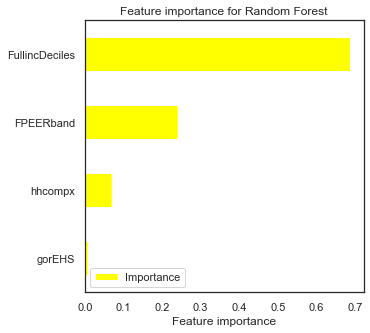

In [119]:
# Calculate feature importance
features_log = pd.DataFrame(clf_rf.feature_importances_, index = X_train.columns.tolist(), 
                            columns = ['Importance'])
features_log = features_log.sort_values(by='Importance', ascending=True)

features_log.plot(kind='barh', figsize=(5,5), color = 'yellow')
plt.xlabel('Feature importance')
plt.title('Feature importance for Random Forest')
plt.show()



The model shows that importance is placed on the full income deciles as this is a large factor on fuel poverty. This is understandable as the less income households will be less unlikely to be able to pay higher fuel prices and thus results in the households to remain under the fuel poverty.

It is also interesting to see that FPEERband has a larger affect on the fuel poverty than one might have thought. This does explain why in historical data that the majority of poor band rated houses belonged to people in lower income deciles and people within the fuel poverty flag.

Houshold compositon will affect fuel expenditure as more people are within a household, the more fuel will be used thus higher fuel expenditure. If the income is not high enough to offset the expenditure, the household will be plunged into fuel poverty.

What is very surprising is the low importance of region. As each region will have different demographics, house prices and income deciles. As it would be expected to have a bigger factor within the model.


###   Random forest model of the lowest decile:

In [120]:
# Random forest 
clf_rf1 = RandomForestClassifier(random_state = 33, n_estimators=50, max_depth=5, 
                                min_samples_leaf=30, max_features=4)
clf_rf1.fit(X_train1, Y_train1)
pred_clf_rf1 = clf_rf1.predict(X_test1)
proba_clf_rf1 = clf_rf1.predict_proba(X_test1)

In [121]:
# Construct confusion matrix for restricted value
print(metrics.confusion_matrix(Y_test1, pred_clf_rf1))

[[613 106]
 [204 613]]


In [122]:
# Print classification report for Random forest
print(metrics.classification_report(Y_test1, pred_clf_rf1))

auc = metrics.roc_auc_score(Y_test1, proba_clf_rf1[:,1])
print("AUC: ",auc)

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       719
           1       0.85      0.75      0.80       817

    accuracy                           0.80      1536
   macro avg       0.80      0.80      0.80      1536
weighted avg       0.80      0.80      0.80      1536

AUC:  0.8775116057764166


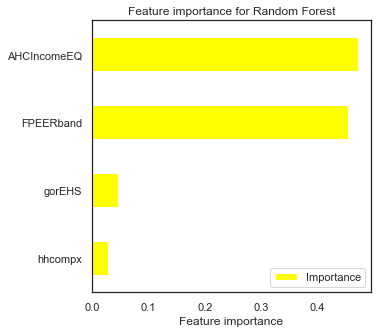

In [123]:
# Calculate feature importance
features_log = pd.DataFrame(clf_rf1.feature_importances_, index = X_train1.columns.tolist(), 
                            columns = ['Importance'])
features_log = features_log.sort_values(by='Importance', ascending=True)

features_log.plot(kind='barh', figsize=(5,5), color = 'yellow')
plt.xlabel('Feature importance')
plt.title('Feature importance for Random Forest')
plt.show()

Like the decision tree, the random forest models again assigns the most importance to income albeit less, and the energy efficiency rating increases in importance considerably.